In [1]:
import getpass
from typing import Optional

import async_retriever as ar
import cytoolz as tlz
import geopandas as gpd
import numpy as np
import pandas as pd
import proplot
from pygeohydro import NWIS
from pynhd import NLDI, AGRBase

In [2]:
with_key = False

key = getpass.getpass("Census dev key:") if with_key else None

In [3]:
def catchments(station: str) -> gpd.GeoDataFrame:
    """Get local catchments for a USGS station."""
    nldi = NLDI()
    nwis = NWIS()

    info = nwis.get_info({"site": station})
    coords = (info.dec_long_va.iloc[0], info.dec_lat_va.iloc[0])
    trib = nldi.navigate_byloc(coords, "upstreamTributaries", "flowlines")

    url = "https://watersgeo.epa.gov/arcgis/rest/services/NHDPlus/NHDPlus/MapServer"
    epa = AGRBase(url, layer="catchment")
    wb = epa.byids("FEATUREID", trib.nhdplus_comid.to_list())
    wb.columns = [c.lower() for c in wb.columns]
    return wb.reset_index(drop=True)

In [4]:
def get_census_pop(wb: gpd.GeoDataFrame, key: Optional[str] = None) -> gpd.GeoDataFrame:
    """Get population data for local catchments."""
    # Get census's GEOIDs for catchments
    url = "https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Tracts_Blocks/MapServer"
    tiger = AGRBase(url, layer="2020 census blocks")
    geoid = tiger.bygeom(wb.geometry.unary_union)

    # Keep only the relevant columns
    cols = ["STATE", "COUNTY"]
    geoid = geoid[["GEOID"] + cols + ["geometry"]].set_index("GEOID")

    # Compute blocks area
    geoid["area_sqkm"] = geoid.to_crs(5070).geometry.area * 1e-6

    # Get population data for all the blocks based on state and county
    grp = geoid.groupby(cols).groups
    census_api = "https://api.census.gov/data/2020/dec/pl"
    payload = [
        {"get": "GEO_ID,P1_001N", "for": "block:*", "in": f"state:{s} county:{c}"} for s, c in grp
    ]
    if key is not None:
        payload = [{"params": {**p, "key": key}} for p in payload]
    else:
        payload = [{"params": p} for p in payload]
    resp = ar.retrieve_json([census_api] * len(payload), payload)

    # Convert to pandas dataframe
    pop = pd.DataFrame(tlz.concat(r[1:] for r in resp), columns=resp[0][0])
    pop["GEO_ID"] = pop["GEO_ID"].str.split("US").str[1]
    pop = pop.set_index("GEO_ID").P1_001N

    # Merge with census GEOIDs
    geoid = geoid.merge(pop, left_index=True, right_index=True, how="left")
    geoid["P1_001N"] = pd.to_numeric(geoid["P1_001N"])

    # Merge with catchments using spatial indexing
    wb_idx, g_idx = geoid.sindex.query_bulk(wb.geometry)
    merged_idx = tlz.merge_with(list, ({w: g} for w, g in zip(wb_idx, g_idx)))

    # Compute total population within catchments by aggregating block populations
    p1 = [
        (w, geoid.iloc[g]["P1_001N"].sum(), geoid.iloc[g]["area_sqkm"].sum())
        for w, g in merged_idx.items()
    ]
    p1 = pd.DataFrame(p1, columns=["index", "population", "area_sqkm"])
    p1 = p1.set_index("index")

    # Prorate population by area
    wb["population"] = p1.population * wb["areasqkm"] / p1.area_sqkm
    wb["population"] = np.floor(wb["population"]).astype(int)
    return wb

In [5]:
wb = get_census_pop(catchments("08075000"))

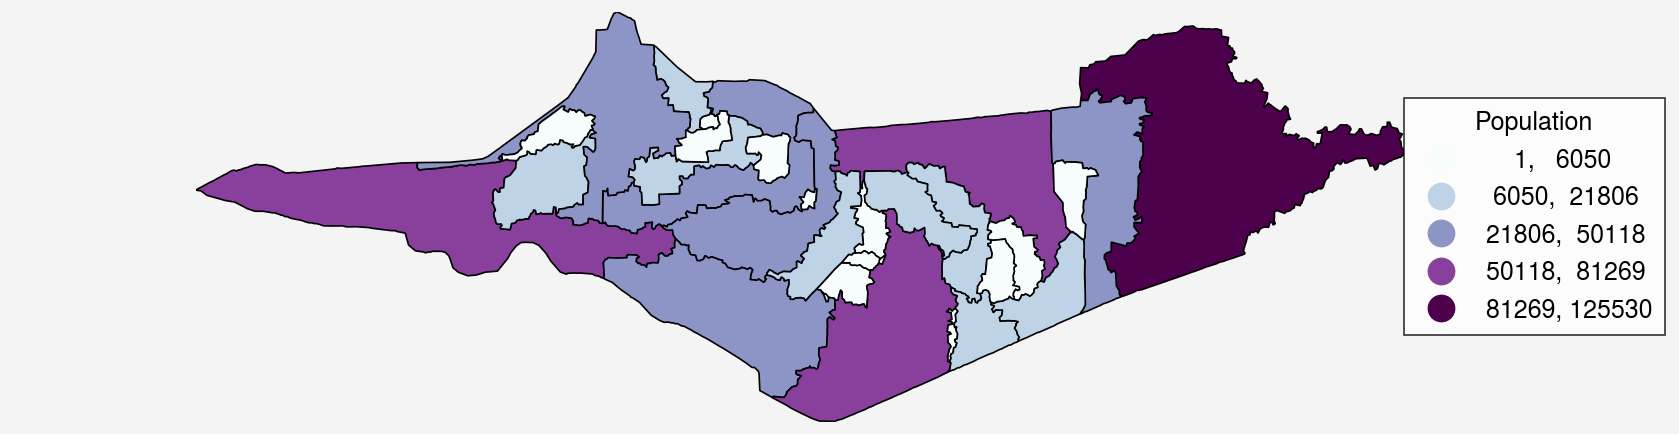

In [6]:
_, ax = proplot.subplots(refwidth=8)
wb.plot(
    ax=ax,
    column="population",
    scheme="FisherJenks",
    k=5,
    cmap="BuPu",
    edgecolor="k",
    legend=True,
    legend_kwds={
        "loc": "center left",
        "bbox_to_anchor": (1, 0.5),
        "fmt": "{:.0f}",
        "ncol": 1,
        "title": "Population",
    },
)
ax.set_axis_off()
ax.margins(0)